In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import  psycopg2

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/blaine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/blaine/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [4]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [5]:
 conn = psycopg2.connect(
     host='localhost', 
     dbname='cpdp', 
     user='blaine', 
     password='postgres'
 )

In [6]:
doc_tags_df = pd.read_sql_query(
    "SELECT * FROM data_document_tags WHERE document_text <> ''",
    conn
)

doc_tags_df.head()

,id,allegation_id,document_text,url,text_bad,incident_date,allegation_name,title,allegation_category,organization,nudity_penetration,sexual_harassment_remarks,sexual_humiliation_extortion_or_sex_work,tasers,trespass,racial_slurs,planting_drugs_guns,neglect_of_duty,irrational_aggressive_unstable,searching_arresting_minors
0,2,315524,SUMMARY REPORT DIGEST- COMPLAINT REGISTER INVE...,https://assets.documentcloud.org/documents/440...,true,2006-08-24,Neglect Of Duty,CRID 315524 CR,Operation/Personnel Violations,CR,False,False,False,False,False,False,False,False,False,False
1,4,315343,COMMAND CHANNEL REVIEW A Sasso Emp 14982 NW 1 ...,https://assets.documentcloud.org/documents/457...,,2006-07-21,Illegal Arrest / False Arrest,CRID 315343 CR,False Arrest,CR,False,False,False,False,False,False,False,False,False,False
2,7,314992,SUMMARY REPORT DIGEST- COMPLAINT REGISTER INVE...,https://assets.documentcloud.org/documents/433...,,2006-08-17,Excessive Force / On Duty - Injury,CRID 314992 CR,Use Of Force,CR,False,False,False,True,False,False,True,False,False,False
3,9,314642,SUMMARY REPORT DIGEST- DATE OF REPORTIDAY-MO.-...,https://assets.documentcloud.org/documents/433...,,2006-07-14,Domestic Altercation - Physical Abuse,CRID 314642 CR,Domestic,CR,False,False,False,False,False,False,False,False,False,False
4,13,313931,SUM MARY REPORT I DATE OF REPORT IDAY-MO COMP...,https://assets.documentcloud.org/documents/440...,,2006-07-01,Excessive Force / On Duty - Injury,CRID 313931 CR,Use Of Force,CR,False,False,False,False,False,False,False,False,False,False


In [7]:
# NLTK stop words
stop_words = stopwords.words('english')
additional_stopwords = [
    'summary', 'report', 'complaint', 'investigation', 'police', 'department',
    'recommendation', 'days', 'original', 'assigned', 'unit', 'accused', 'office', 'internal', 'division','western'
    'employee', 'name', 'star', 'date', 'duty', 'civilian', 'state', 'complainant', 'without', 
    'sergeant', 'stated', 'ember', 'list', 'rank', 'address', 'telephone', 'evidence', 'history', 
    'allegation', 'attachment', 'action', 'made', 'investigator', 'sheet', 'general', 'section', 'sworn', 
    'approximately', 'contact', 'received', 'unfounded', 'arrest', 'used', 'time', 'status', 'court', 'city', 
    'location', 'district', 'residence', 'officer', 'told', 'person', 'interview', 'number', 
    'page', 'view', 'review', 'subject', 'type', 'search', 'case', 
    'independent', 'authority', 'related', 'pending', 'upon', 'also', 'information', 'statement', 
    'said', 'order', 'request', 'board', 'respondent', 'superintendent', 'print', 'offender', 'chief',
    'st', 'mar', 'channel', 'total', 'form', 'investigative', 'th', 'el', 'one', 'see', 'use', 'po', 'may',
    'log', 'yes', 'noted', 'non', 'signature', 'am', 'smith', 'august', 'these', 'indicate', 'both', 'result',
    'id', 'attached', 'each', 'get', 'whether', 'copy', 'june', 'before', 'lieutenant', 'regarding', 'summarize',
    'could', 'what', 'ave', 'march', 'row', 'so', 'available', 'me', 'them', 'between', 'its', 'dob', 'day', 'my',
    'being', 'your', 'two', 'either', 'because', 'supervisor', 'print', 'st', 'mar', 'does', 'their', 'do', 'form',
    'superintendent', 'been', 'into', 
]
stop_words.extend(additional_stopwords)
stop_words = set(stop_words)

english_words = set(nltk.corpus.words.words())
ps = nltk.stem.PorterStemmer()

In [8]:
def doc_to_words(doc):
    doc_text = doc[1][2]
    words = gensim.utils.simple_preprocess(str(doc_text), deacc=True)
    words = [w for w in words if w in english_words]
    return words
    
tokens = []
for doc in doc_tags_df.iterrows():
    data_words = doc_to_words(doc)
    tokens.append(data_words)

In [9]:
word_counts = {}
for doc in tokens:
    for word in doc:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1
            
import operator
sorted_word_counts = sorted(word_counts.items(), key=operator.itemgetter(1))
for key, value in sorted_word_counts:
    if value > 500:
        print(key, value)

overall 502
now 502
listed 504
way 507
through 509
continued 510
none 513
driver 518
over 520
attempt 523
policy 526
lockup 533
occurrence 536
went 537
suspended 539
special 539
warranted 542
video 544
security 545
apartment 548
informed 548
non 549
found 551
inside 555
aid 558
away 561
signature 566
struck 568
result 570
audio 575
deceased 576
complimentary 578
august 579
id 584
arresting 587
secure 589
attention 593
stop 593
avenue 598
response 600
we 601
disprove 601
am 602
these 602
provided 606
age 610
decision 613
appointment 614
get 619
park 620
watch 624
accountability 624
lieutenant 632
noted 633
verbal 635
both 638
several 640
head 644
attached 646
aide 651
ave 652
row 656
copy 661
front 662
before 666
necessary 669
regarding 669
june 671
indicate 675
smith 675
included 680
deputy 683
initiate 687
each 688
whether 690
assignment 690
squad 693
discharge 693
charge 702
ce 702
could 704
room 706
position 707
gun 708
what 713
agreement 713
available 719
side 719
so 720
between 72

In [10]:
bigram = gensim.models.Phrases(tokens, min_count=5, threshold=100) 
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [11]:
for token_idx, token_list in enumerate(tokens):
    words = token_list
    words = [w for w in words if not w in stop_words]
    tokens[token_idx] = words
    

words_bigrams = [bigram_mod[doc] for doc in tokens]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    output = []
    for doc in texts:
        doc = nlp(' '.join(doc))
        output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return output

data_lemmatized = lemmatization(words_bigrams)
print(data_lemmatized[0])
# doc_str = nlp(' '.join(words))
# words = [token.lemma_ for token in doc_str if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']]

['classify', 'sustain', 'disciplinary', 'suspension', 'submit', 'submit', 'attention', 'administrator', 'charge', 'professional', 'assistant', 'employee', 'run', 'appointment', 'home', 'elixir', 'additional', 'male', 'white', 'unknown', 'warrant', 'gas', 'station', 'full', 'substance', 'danger', 'go', 'physical', 'visible', 'injury', 'normal', 'influence', 'property', 'building', 'ammo', 'ilium', 'system', 'injure', 'injure', 'medical', 'aid', 'injure', 'medical', 'aid', 'deceased', 'box', 'gallon', 'prove', 'support', 'support', 'sustain', 'member', 'record', 'previous', 'include', 'support', 'support', 'hull', 'ivy', 'overall', 'sustain', 'example', 'warrant', 'member', 'member', 'suspend', 'exceed', 'run', 'mum', 'command', 'paper', 'continue', 'item', 'additional', 'employee', 'code', 'employee', 'employee', 'employee', 'unknown', 'warrant', 'reason', 'vehicle', 'additionally', 'full', 'aim', 'unknown', 'cation', 'additionally', 'scene', 'full', 'message', 'machine', 'mail', 'list'

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 3), (2, 2), (3, 3), (4, 4), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 4), (13, 1), (14, 3), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 3), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 6), (41, 2), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 7), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 4), (63, 1), (64, 1), (65, 1), (66, 3), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 8), (78, 5), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 3), (87, 1), (88, 2), (89, 1), (90, 1), (91, 4), (92, 2), (93, 1), (94, 1), (95, 5), (96, 7), (97, 1), (98, 1), (99, 2), (100, 1), (101, 1), (102, 1), (103, 2), (104, 3), (105, 1), (106, 1), (107, 1), (108, 3), (109, 1), (110, 1)

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=12, 
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=20,
    alpha='auto',
    per_word_topics=True
)

In [13]:
def train_and_measure(max_cls, corpus, id2word, data_lemma):
    models = []
    perplexities = []
    coherences = []
    
    for i in range(max_cls+1):
        if i <= 1: continue
            
        print('training model for class size: ', i)
            
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=i, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=20,
            alpha='auto',
            per_word_topics=True
        )
        models.append(model)
        perplexity = model.log_perplexity(corpus)
        perplexities.append(perplexity)
        cv_model = CoherenceModel(model=model, texts=data_lemma, dictionary=id2word, coherence='c_v')
        coherence = cv_model.get_coherence()
        coherences.append(coherence)
        
        print('perplexity: ', perplexity)
        print('coherence: ', coherence)
        print('---')

    return models, perplexities, coherences
    

In [14]:
models, perplexities, coherences = train_and_measure(20, corpus, id2word, data_lemmatized)

training model for class size:  2
perplexity:  -7.020944646190513
coherence:  0.5568384111325989
---
training model for class size:  3
perplexity:  -6.953383020095477
coherence:  0.5295713294991713
---
training model for class size:  4
perplexity:  -6.87865339441277
coherence:  0.6008220721816853
---
training model for class size:  5
perplexity:  -6.843938159750939
coherence:  0.5853396143389198
---
training model for class size:  6
perplexity:  -6.83629564432929
coherence:  0.5387465266539048
---
training model for class size:  7
perplexity:  -6.835546604610677
coherence:  0.5681906139176239
---
training model for class size:  8
perplexity:  -6.859541457043492
coherence:  0.5553901838851398
---
training model for class size:  9
perplexity:  -6.8985886263157905
coherence:  0.5578410007508023
---
training model for class size:  10
perplexity:  -6.9746226468859165
coherence:  0.582372359426724
---
training model for class size:  11
perplexity:  -7.119945473736265
coherence:  0.5264879291

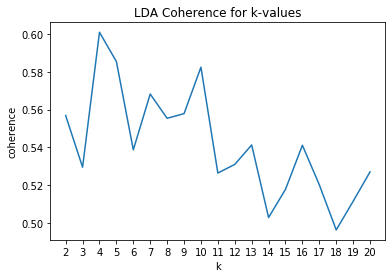

In [15]:
k_values = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.plot(k_values, coherences)
plt.title('LDA Coherence for k-values')
plt.xlabel('k')
plt.xticks(k_values)
plt.ylabel('coherence')
plt.savefig('images/k_values.png')

In [76]:
lda_model.print_topics()

[(0,
  '0.077*"beat" + 0.032*"arrest" + 0.029*"victim" + 0.026*"age" + 0.015*"take" + 0.014*"event" + 0.014*"medical" + 0.013*"system" + 0.013*"relationship" + 0.012*"personnel"'),
 (1,
  '0.044*"incident" + 0.029*"audio" + 0.027*"weapon" + 0.025*"apply" + 0.024*"victim" + 0.022*"witness" + 0.020*"employee" + 0.019*"appeal" + 0.018*"face" + 0.018*"command"'),
 (2,
  '0.193*"detective" + 0.034*"attorney" + 0.033*"homicide" + 0.028*"supplementary" + 0.026*"criminal" + 0.023*"advise" + 0.021*"tow" + 0.013*"counsel" + 0.013*"accordingly" + 0.010*"line"'),
 (3,
  '0.083*"weapon" + 0.067*"member" + 0.033*"fire" + 0.029*"discharge" + 0.022*"force" + 0.020*"incident" + 0.019*"first" + 0.015*"strike" + 0.013*"draw" + 0.013*"specify"'),
 (4,
  '0.033*"sustain" + 0.033*"disciplinary" + 0.030*"member" + 0.026*"support" + 0.017*"employee" + 0.015*"warrant" + 0.013*"unknown" + 0.013*"incident" + 0.012*"witness" + 0.012*"file"'),
 (5,
  '0.019*"vehicle" + 0.014*"go" + 0.014*"incident" + 0.011*"take" 

In [18]:
cv_max = max(coherences[4:-1])
cv_max_idx = coherences.index(cv_max)
print(cv_max_idx, cv_max)
lda_model = models[cv_max_idx]

8 0.582372359426724


In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.9746209262209895

Coherence Score:  0.582372359426724


In [20]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/anaconda3/envs/cpdp/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.011310  0.032672       1        1  23.002439
6     -0.223847 -0.070055       2        1  17.640736
7      0.149773  0.088047       3        1  16.186506
0     -0.243591 -0.017182       4        1   9.035173
3      0.049685 -0.291277       5        1   7.925692
1      0.003383  0.178713       6        1   7.646133
8     -0.179846  0.024974       7        1   6.454746
5      0.163940 -0.216818       8        1   6.318121
9      0.017253  0.203575       9        1   5.329508
2      0.251940  0.067352      10        1   0.460950, topic_info=     Category         Freq       Term        Total  loglift  logprob
96    Default  3978.000000     member  3978.000000  30.0000  30.0000
157   Default  2637.000000    vehicle  2637.000000  29.0000  29.0000
126   Default  2086.000000       rule  2086.000000  28.0000  28.0000
377   Default  1715.000000     weapon  1715.000000  27.0000  27.0000
390   Default  1602.000000       beat  1602.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
32    Topic10     9.110104   criminal   276.210083   1.9679  -4.9208
1325  Topic10     8.278541      shoot   323.053162   1.7155  -5.0165
452   Topic10     4.438703       want   123.428764   2.0543  -5.6398
2209  Topic10     3.208329      theft    51.950081   2.5951  -5.9644
1415  Topic10     3.086907  authorize    93.281487   1.9712  -6.0030

[647 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
3543      8  0.994963  accountability
595       5  0.793473         achieve
595       8  0.204767         achieve
170       7  0.981002     acquisition
1         1  0.010454      additional
...     ...       ...             ...
454       7  0.089696           write
454       8  0.344771           write
380       1  0.982326            yell
5713      8  0.974088          yellow
2457      9  0.986209             yet

[1196 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 8, 1, 4, 2, 9, 6, 10, 3])

In [25]:
pyLDAvis.save_html(vis, 'lda.html')

In [26]:
first_topic_ids = []
first_topic_probs = []
second_topic_ids = []
second_topic_probs = []
third_topic_ids = []
third_topic_probs = []

# print(list(lda_model.get_document_topics(corpus)))

for doc_topic in list(lda_model.get_document_topics(corpus)):
    doc_topic = sorted(doc_topic, key=lambda x: x[1]*-1)
    if len(doc_topic) > 0:
        first_topic_ids.append(int(doc_topic[0][0])+1)
        first_topic_probs.append(doc_topic[0][1])
    else:
        first_topic_ids.append(None)
        first_topic_probs.append(None)
    if len(doc_topic) > 1:
        second_topic_ids.append(int(doc_topic[1][0])+1)
        second_topic_probs.append(doc_topic[1][1])
    else:
        second_topic_ids.append(0)
        second_topic_probs.append(None) 
    if len(doc_topic) > 2:
        third_topic_ids.append(int(doc_topic[2][0])+1)
        third_topic_probs.append(doc_topic[2][1])
    else:
        third_topic_ids.append(0)
        third_topic_probs.append(None)

doc_tags_df['topic1_id'] = first_topic_ids
doc_tags_df['topic1_prob'] = first_topic_probs
doc_tags_df['topic2_id'] = second_topic_ids
doc_tags_df['topic2_prob'] = second_topic_probs
doc_tags_df['topic3_id'] = third_topic_ids
doc_tags_df['topic4_prob'] = third_topic_probs

topics_df = doc_tags_df[['id', 'topic1_id', 'topic1_prob', 'topic2_id', 'topic2_prob', 'topic3_id', 'topic4_prob']]

topics_df.to_csv('document_topics_map.csv', index=False)
topics_df.head()

,id,topic1_id,topic1_prob,topic2_id,topic2_prob,topic3_id,topic4_prob
0,2,1,0.455364,7,0.270309,5,0.157144
1,4,7,0.512903,9,0.172453,10,0.155601
2,7,5,0.583686,1,0.303854,8,0.091789
3,9,5,0.377968,1,0.306583,6,0.109929
4,13,1,0.484361,5,0.290761,8,0.172197


In [27]:
doc_cat_df = pd.DataFrame()
ids = []
terms = [[''],[''],[''],[''],[''],[''],[''],[''],[''],['']]

for i in range(10):
    ids.append(i)
    for topic_term_idx, topic_term in enumerate(list(lda_model.get_topic_terms(i))):
        terms[topic_term_idx].append(id2word[topic_term[0]])
        
# doc_cat_df['id'] = ids
doc_cat_df['id'] = list(range(0, 11))
doc_cat_df['term1'] = terms[0]
doc_cat_df['term2'] = terms[1]
doc_cat_df['term3'] = terms[2]
doc_cat_df['term4'] = terms[3]
doc_cat_df['term5'] = terms[4]
doc_cat_df['term6'] = terms[5]
doc_cat_df['term7'] = terms[6]
doc_cat_df['term8'] = terms[7]
doc_cat_df['term9'] = terms[8]
doc_cat_df['term10'] = terms[9]

doc_cat_df.to_csv('document_topics.csv', index=False)
doc_cat_df

,id,term1,term2,term3,term4,term5,term6,term7,term8,term9,term10
0,0,,,,,,,,,,
1,1,injure,member,support,disciplinary,sustain,professional,medical,property,injury,visible
2,2,weapon,member,discharge,battery,fire,incident,force,firearm,injury,first
3,3,detective,homicide,supplementary,attorney,murder,inspector,taxi,government,emma,strip
4,4,rule,decision,follow,hear,hearing,conduct,write,guilty,suspension,agreement
5,5,go,incident,leave,male,sustain,back,strike,take,face,door
6,6,rule,violation,involve,copa,accountability,write,work,would,give,find
7,7,sustain,member,disciplinary,support,warrant,employee,incident,command,witness,file
8,8,vehicle,stop,car,drive,take,driver,individual,arrest,involve,seat
9,9,incident,witness,employee,face,audio,victim,command,preliminary,weapon,sustain


7442